In [5]:
import cv2
import os
import numpy as np
from zipfile import ZipFile

#import gdal
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style()

from scipy import ndimage as ndi
from skimage import feature

%matplotlib inline

#http://www.mdpi.com/2072-4292/8/10/868/htm
#https://medium.com/@eos_da/applying-neural-network-and-local-laplace-filter-methods-to-very-high-resolution-satellite-imagery-3b203e5cc444

# Data Review

In [7]:
def download_kml(path):
    """ 
    Extracts a KMZ file from path and outputs a KML doc. 
    
    Args:
        path (str): Path to the kmz archive.
        
    Returns:
        kml: Unarchived file read.
        
    """
    
    kmz = ZipFile(path, 'r')
    return kmz.open('doc.kml', 'r').read()
# kml = download_kml('../data/r36208_9_constellation_airbus_ds_nepal_earthquake_28042015.kmz')
def image_struct(path):
    """ 
    Outputs an image path / name dictionary.
    
    Args:
        path (str): Root of the image files. 
        
    Returns:
        dict: Shape of key: tuple containing the class 'after', 'before', and year of recording.
    
    """
    
    struct = {}
    images = os.listdir(path)
    for img in images:
        if 'after' in img:
            incidence = 'after'
        elif 'before' in img:
            incidence = 'before'
        
        try:
            date = int(img.split('_')[-1].split('.jpg')[0])
            struct[(incidence, date)] = img
        except:
            # Not an appropriate structure for the image data.
            pass
    
    return struct
    
def image_resize(image, size):
    """ 
    Resizes given image object. 
    
    Args:
        image (nd.array): Image array which should be resized.
        size     (tuple): Structure: (width(float), height(float) - shape of the resized image.
      
    Returns:
        nd.array: Resized image. 
        
    """
    
    return cv2.resize(image, size)

def save_image(image, path):
    """ 
    Writes image to path.
    
    Args:
        image (nd.array): Image array that should be saved. 
        path       (str): Save path.  
    
    """
    
    cv2.imwrite(image, path)
    
def display_image(image):
    """
    Plots an image using matplotlib pyplot imshow. 
    
    Args:
        image (nd.array): Image that should be visualised. 
    
    """
    
    plt.imshow(image)
    plt.grid(False)
    plt.show()
    
def gaussian_filter(image, shape=(5,5), dx=0, dy=0, ksize=1):
    """
    Applies a Gaussian smoothing filter to an image array. 
    
    Args:
        image (nd.array): Image array which should be smoothed.
        shape    (float): Odd and positive numbers - size of the kernel. 
        dx       (float): Std of x.
        dy       (float): Std of y.
        
    Returns:
        nd.array: Gaussian filter on top of an image numpy array.
    
    """
    
    return cv2.GaussianBlur(image, shape, dx, dy)

def laplace_filter(image, ddepth=cv2.CV_64F, ksize=1):
    """
    Applies Laplace filter to an image array.
    This will identify areas of rapid change.
    
    Args:
        image (nd.array): Image array which should be transformed.
        ksize      (int): Laplace filter type. s
        
    Returns:
        nd.array: Transformed image.
    
    """
    
    return cv2.Laplacian(image, ddepth=ddepth, ksize=ksize)

def laplasian_of_gaussian(image_gray, sigma=1., kappa=0.75, pad=False):
    """
    Applies Laplacian of Gaussians to grayscale image.
    # https://github.com/amirdel/stanfordHacks/tree/master/notebooks

    Args:
        image_gray (nd.array): Image to apply the laplasian of Gaussian on top of.
        sigma:        (float): Sigma of Gaussian applied to image. <= 0 is None
        kappa:        (float): Difference threshold as factor to mean of image values, <= 0 is None
        pad:          (bool): Flag to pad output w/ zero border, keeping input image size
    
    Returns:
        nd.array: Transformed image. 
    """
    
    assert len(image_gray.shape) == 2
    image = cv2.GaussianBlur(image_gray, (0, 0), sigma) if 0 < sigma else image_gray
    image = cv2.Laplacian(image, cv2.CV_64F)
    rows, cols = image.shape[:2]
    
    # Min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(image[r:rows - 2 + r, c:cols - 2 + c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(image[r:rows - 2 + r, c: cols - 2 + c]
                                     for r in range(3) for c in range(3)))
    
    # Bool matrix for image value positiv (w/out border pixels)
    image_pos = 0 < image[1:rows - 1, 1:cols - 1]
    
    # Bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - image_pos] = 0
    
    # Bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[image_pos] = 0
    
    # Sign change at pixel
    zero_cross = neg_min + pos_max
    
    # Values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., image.max() - image.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    
    # Optional Thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(image).mean()) * kappa
        values[values < thresh] = 0.
    
    image_log = values.astype(np.uint8)
    
    if pad:
        image_log = np.pad(image_log, pad_width=1, mode='constant', constant_values=0)
    
    return image_log

def laplacian_variance(image):
    """
    Applies a Laplace filter on an image and returns its variance. 

    """

    return cv2.Laplacian(image, cv2.CV64F).var()

def sharpen_image(image_first, image_second):
    """
    Sharpens image based on a second image. 

    """

    gray_fist = cv2.cvtColor(image_first, cv2.COLOR_BGR2GRAY)
    gray_second = cv2.cvtColor(image_second, cv2.COLOR_BGR2GRAY)

    height = image_first.shape[1]
    width = image_first.shape[0]

    window = 2
    x_window = window
    y_window = window

    zeros_0 = np.zeros((height, width, 1), np.uint8)
    zeros_1 = np.zeros((height, width, 1), np.uint8)
    zeros_2 = np.zeros((height, width, 1), np.uint8)

    # Colour layers decomposed.
    # For colour order transformation
    #layer_b = image_first[:, :, 0]
    #layer_g = image_first[:, :, 1]
    #layer_r = image_first[:, :, 2]
    layer_o = image_first[:, :, 3]

    while x < width:
        while y < height:
            layer_0 = gray_first[y: y + y_window, x: x + x_window]
            layer_1 = gray_second[y: y + y_window, x: x + x_window]
            layer_2 = layer_o[y: y + y_window, x: x + x_window]

            if 0 not in list(np.asarray(layer_2).reshape(-1)):
                try:
                    l0_lp_var = variance_of_laplacian(layer_0)
                    l1_lp_var = variance_of_laplacian(layer_1)

                    if l0_lp_var < 100:
                        cv2.rectangle(image_first, (x, y), (x + x_window, y + y_window), (0, 0, 255), -1)
                        cv2.rectangle(zeros_0, (x, y), (x + x_window, y + y_window), 255, -1)
                        cv2.rectangle(zeros_0, (x, y), (x + x_window, y + y_window), 255, 3)
                        zeros_0[y, x] = 255
                    if l1_lp_var < 50:
                        cv2.rectangle(image_second, (x, y), (x + x_window, y + y_window, 0, 0, 255))
                        cv2.rectangle(image_second, (x, y), (x + x_window, y + y_window, 255, -1))
                except Exception as exp:
                    raise
            y += 1

        y = 0
        x += 1
        y_window = window

    x = 0
    y = 0

    while x < width:
        while y < height:
            if zeros_0[y, x] == 255 and zeros_1[y, x] < 255 and layer_o[y, x] == 255:
                zeros_2[y, x] = 255
            y += 1
        x += 1
        y = 0 

    print(mat)
    
def slide_template(image, wsize):
    """
    Builds a sliding template.
    
    Args:
        image (nd.array): Image array.
        wsize      (int): Step size.
        
    Returns:
        nd.array: Enhanced image.
    """
    
    new_image = []
    for col in range(image.shape[1] - wsize - 1):
        for row in range(image.shape[0] - wsize - 1):
            window = []
            for k in range(wsize):
                for l in range(wsize):
                    window.append(image[row + k, col + l])
            new_image.append(window)
    return np.asarray(new_image)

def pca(image):
    """
    Perform principal component analysis (PCA) on the given image.
    
    Args:
        image (nd.array): Image as array onto which PCA is performed.
        
    Returns:
        float: 
        
    """
    
    pca = PCA(n_components = 3)
    scores = pca.fit_transform(image)
    return scores, pca.explained_variance_ratio_
    
#def vector_to_raster(vector, output_path, x_size, y_size, options, data_type=gdal.GDT_Int32):
    '''
    This method creates a raster object by burning the values of this
    shape file into a raster with the given resolution.
    '''
    source_layer = vector.get_layer()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    print(source_layer.GetExtent())
    
    x_resolution = int((x_max - x_min) / x_size)
    y_resolution = int((y_max - y_min) / -y_size) 
    print(x_resolution, y_resolution)
    
    LOGGER.info(x_min, x_max, y_min, y_max)
    target_ds = gdal.GetDriverByName(str('GTiff')).Create(output_path, x_resolution, y_resolution, 1, data_type)
    spatial_reference = vector.get_spatial_reference()         
    target_ds.SetProjection(spatial_reference.ExportToWkt())
    target_ds.SetGeoTransform((x_min, x_size, 0, y_max, 0, -y_size))
    gdal.RasterizeLayer(target_ds, [1], source_layer, options=options)
    target_ds.FlushCache()
    
    return raster.Data(output_path) 

In [8]:
img_path = '../data/buildings_set/high_res_amatrice/'
struct = image_struct(img_path)
struct

{('after', 2016): 'img_earthquake_after_small_2016.jpg',
 ('after', 2017): 'img_earthquake_after_small_2017.jpg',
 ('before', 2010): 'img_earthquake_before_small_2010.jpg',
 ('before', 2016): 'img_earthquake_before_small_2016.jpg'}

In [9]:
image_before_2010 = cv2.imread(img_path + struct[('before', 2010)])
image_before_2016 = cv2.imread(img_path + struct[('before', 2016)])
image_after_2016  = cv2.imread(img_path + struct[('after', 2016)])
image_after_2017  = cv2.imread(img_path + struct[('after', 2017)])

images_before = [image_before_2010, image_before_2016]
images_after  = [image_after_2016,  image_after_2017]

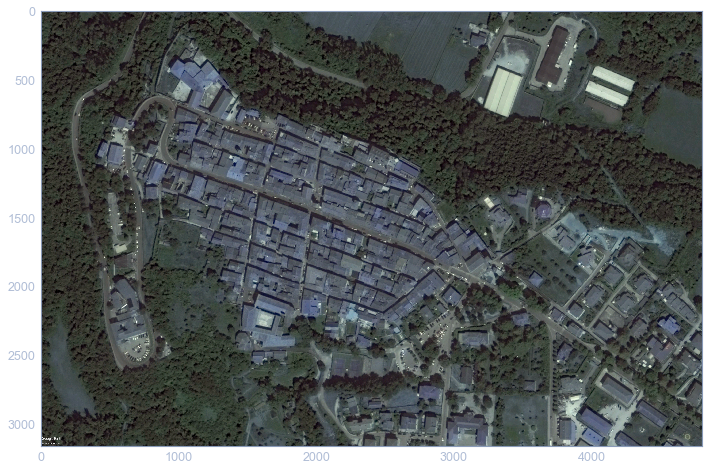

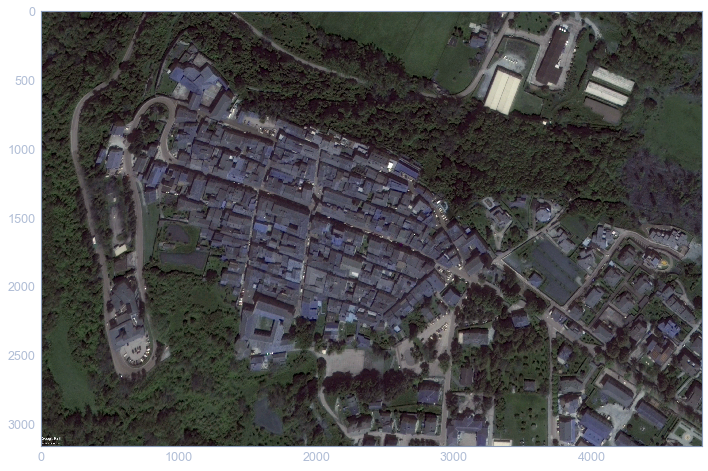

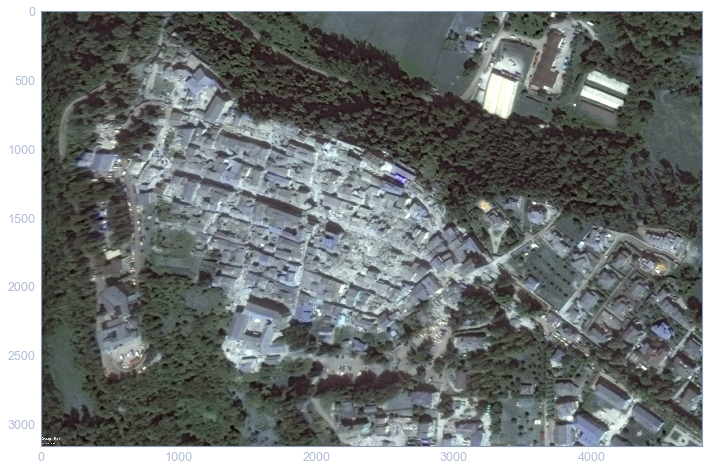

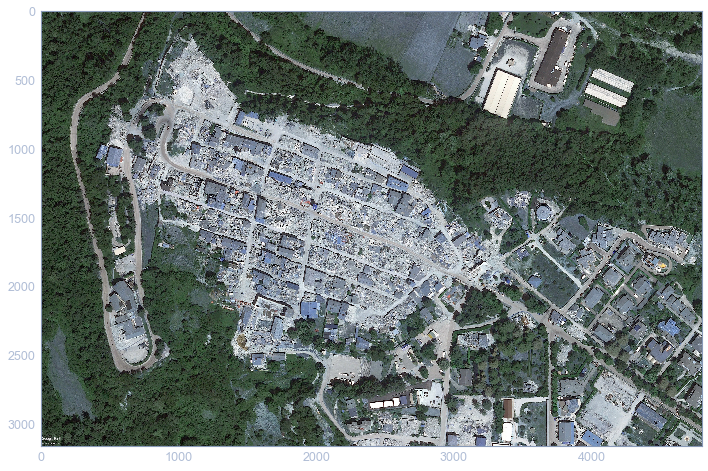

In [10]:
for image in np.concatenate([images_before, images_after]):
    plt.figure(figsize=(12,8))
    display_image(image)

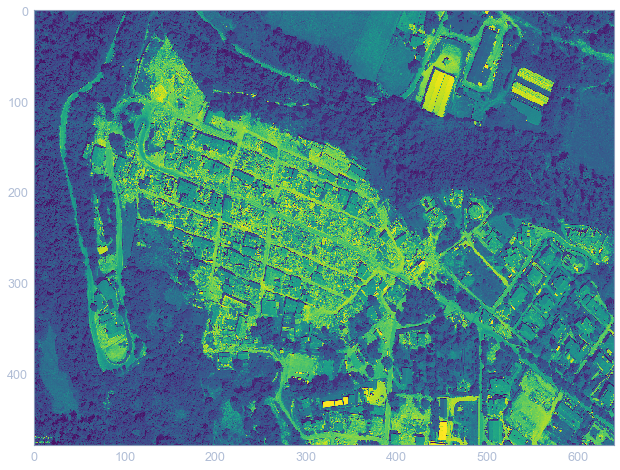

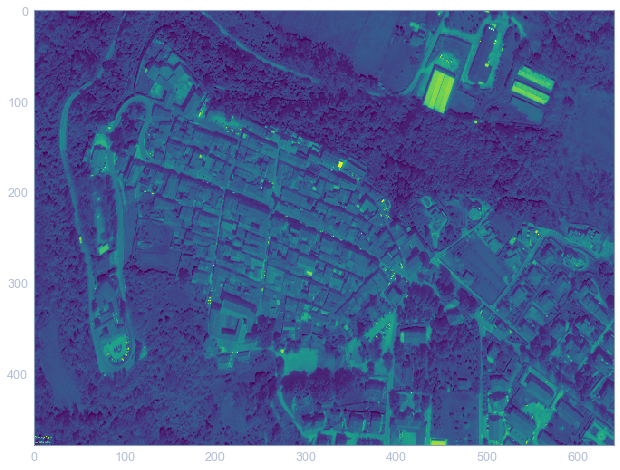

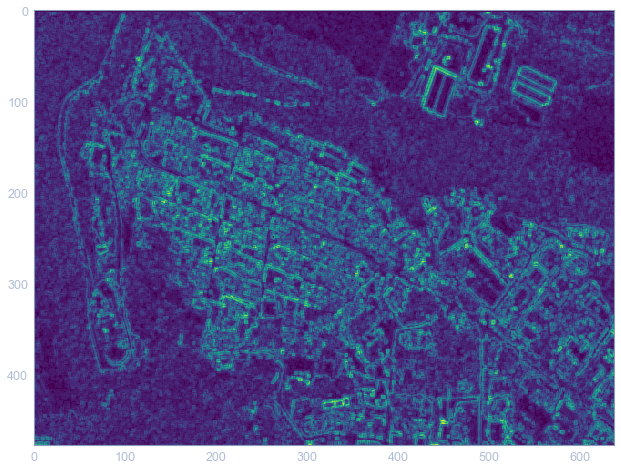

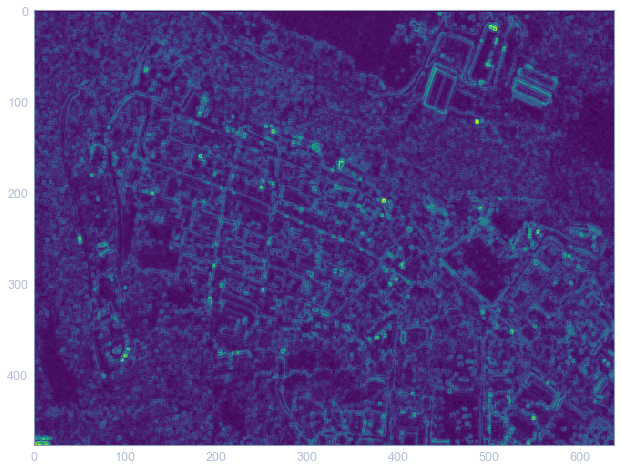

In [11]:
image_after = image_resize(image_after_2017, (640,480))
image_after = cv2.cvtColor(image_after, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
display_image(image_after)

image_before = image_resize(image_before_2016, (640,480))
image_before = cv2.cvtColor(image_before, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
display_image(image_before)

image_laplace = laplasian_of_gaussian(image_after)
plt.figure(figsize=(12,8))
display_image(image_laplace)

image_laplace = laplasian_of_gaussian(image_before)
plt.figure(figsize=(12,8))
display_image(image_laplace)

In [12]:
edges_before = feature.canny(cv2.cvtColor(image_before_2016, cv2.COLOR_BGR2GRAY), sigma=3)
edges_after = feature.canny(cv2.cvtColor(image_after_2017, cv2.COLOR_BGR2GRAY), sigma=3)

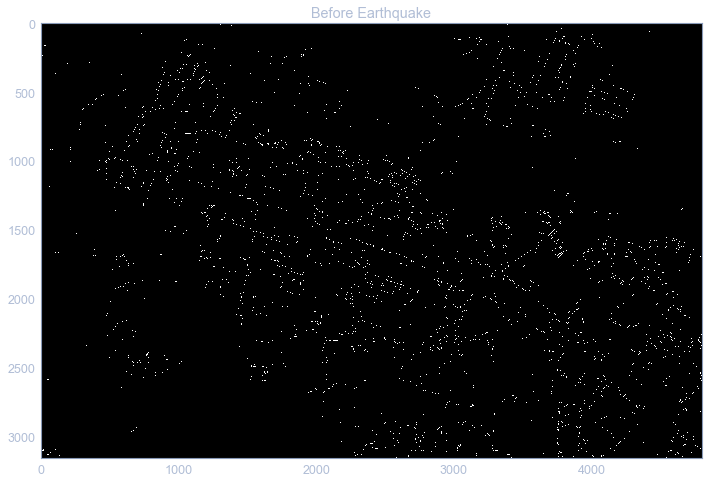

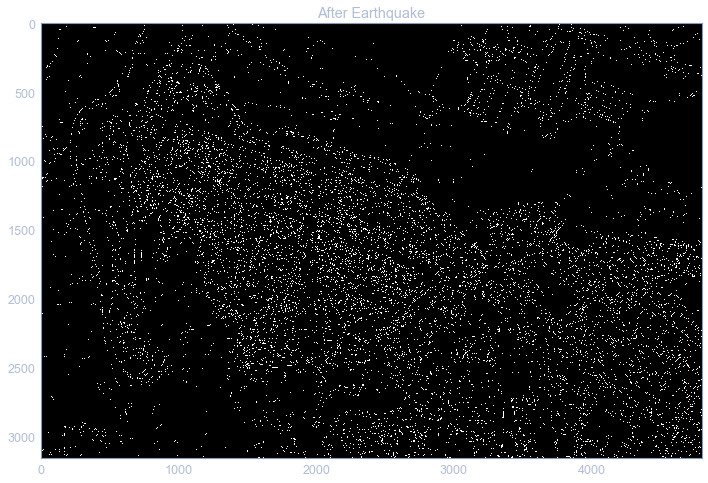

In [13]:
plt.figure(figsize=(12,8))
plt.imshow(edges_before, cmap=plt.cm.gray)
plt.grid(False)
plt.title('Before Earthquake')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(edges_after, cmap=plt.cm.gray)
plt.grid(False)
plt.title('After Earthquake')
plt.show()

In [14]:
image_resized = cv2.cvtColor(image_resize(image_after_2017, (640, 480)), cv2.COLOR_BGR2GRAY)
print(image_resized.shape, )

image = slide_template(image_resized, 3)
print(image.shape)

scores, explained = pca(image)
print(scores.shape)

(480, 640)
(302736, 9)
(302736, 3)


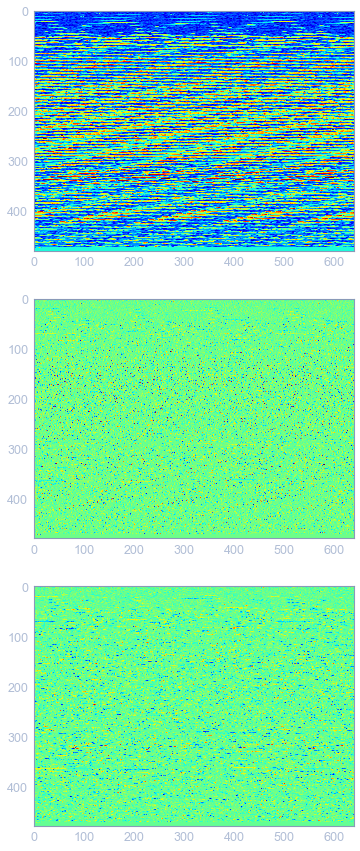

In [15]:
padding = np.zeros((image_resized.shape[0] * image_resized.shape[1] - image.shape[0], 3))
scores_padded = np.concatenate([scores,padding]).reshape(640, 480, 3)

fig = plt.figure(figsize=(15, 15))
for i in range(3):
    fig.add_subplot(3, 1, 1 + i)
    size = int(np.sqrt(scores_padded[:,0].size))
    grid = scores_padded[:, :, i].reshape(480, 640)
    plt.grid(False)
    plt.imshow(grid, cmap='jet')

# Images 

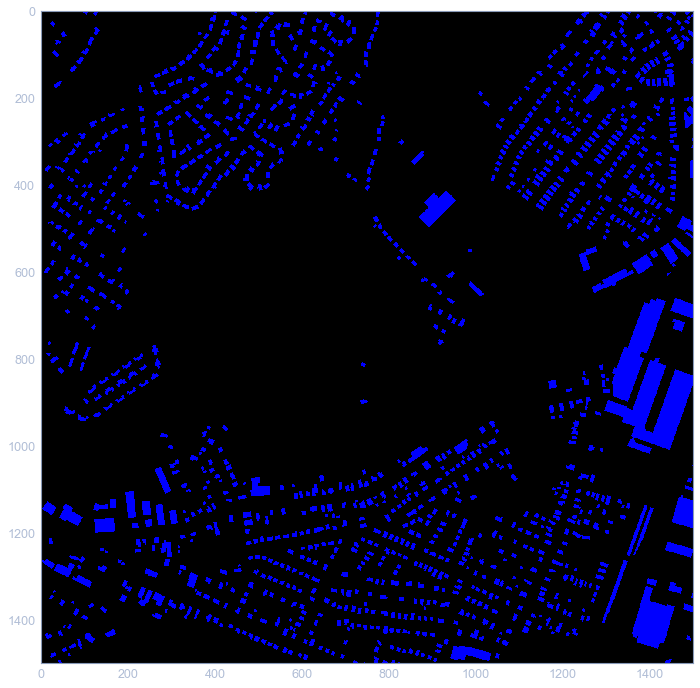

In [16]:
img_name = '22978885_15.tiff'
path = '../data/buildings_set'

path_train = f'{path}/images/train'
path_layer = f'{path}/labels/train'

train_sat = os.listdir(path_train)
train_truth = os.listdir(path_layer)

#plt.imshow(cv2.imread(f'{path_train}/{img_name}'))
plt.figure(figsize=(12,12))  
plt.imshow(cv2.imread(f'{path_layer}/{img_name}'[:-1]))
plt.grid(False)

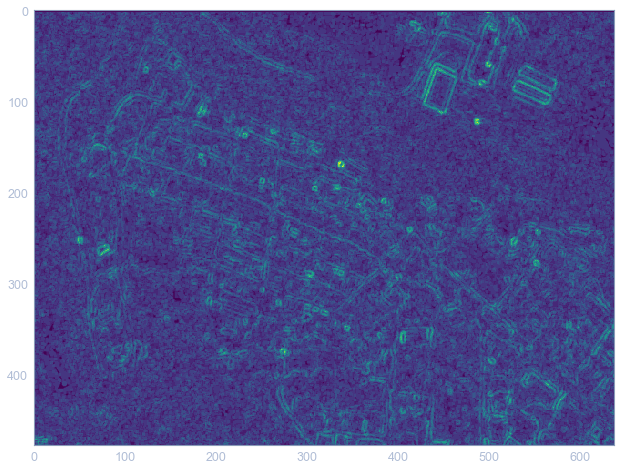

In [35]:
plt.figure(figsize=(12,8))
plt.imshow(laplasian_of_gaussian(image_before, sigma=2, kappa=0.8))
plt.grid(False)